# Building a Transformer Encoder from Scratch (Step-by-Step)

This guide will walk you through building the Transformer Encoder from scratch using PyTorch, based on the paper [*Attention Is All You Need*](https://arxiv.org/abs/1706.03762).

> We'll cover everything step-by-step with code, explanations, and intuition. You don't need to have read the full paper beforehand.

---

## What You'll Do Here

-   Understand what self-attention is and why it's useful.
-   Learn how each component (like multi-head attention, feed-forward layers) fits into the encoder.
-   Implement every part from scratch, with explanations.
-   Come away with a working Transformer encoder model that you understand.

---

## GitHub Repository

The full code, architecture diagram, and README are available in the GitHub repo:
[github.com/nls-forev/transformer-from-scratch](https://github.com/nls-forev/transformer-from-scratch)

---

> You can run each cell and follow along. If you get stuck, reread the explanations or experiment with the code. I assume you have a basic understanding of tensor operations and some sequential data processing concepts.

Let’s get started.

This is the architecture we will implement

![encoder_architecture](encoder_architecture.png)

# Introduction

The goal is to teach our model to understand words and generate meaningful sentences.

Consider the sentence:

> **"I'm a programmer. I build stuff."**

The model needs to determine what you're talking about and how each word relates to the others. This involves understanding grammar, word order, and meaning simultaneously.

---

### What came before Transformers?

Before Transformers, Recurrent Neural Networks (RNNs) were common.

In an RNN, the model processes words sequentially:
- First, it sees `"Im"`, processes it, and stores information in its memory.
- Then, it sees `"a"`, processes it, and updates its memory.
- This continues for `"programmer"`, and so on.

This approach worked reasonably well for simpler tasks. However, RNNs tend to struggle with longer sentences or more complex grammar.

![rnn](rnn.png)

In the image above:

-   `h₀` represents the initial memory state; the model starts with no prior information.
-   `x₁` is the first word, `"Im"`.
-   The RNN processes `x₁`, updates its memory (hidden state `h`), and produces an output `y₁`.

This process repeats:

-   `x₂` is `"a"`, `x₃` is `"programmer"`, and so forth.
-   Each word updates the memory (`h`) and yields a new output (`y`).
-   `'n'` denotes the number of words in the sentence, so this repeats for `n` time steps.

When the last word is processed, the memory is updated a final time, and the model produces `yₙ`, the output for the last word.

---

So, what is this `yₙ` output?

It depends on the task the model is trained for:

-   For **translation**, `yₙ` could be part of the translated sentence.
-   For **text classification**, `yₙ` might represent the model’s decision (e.g., positive or negative sentiment).
-   For a **language model**, it might predict the next word.

In essence, `yₙ` is the final output used to solve the task, based on all information processed up to the last word.

But there's a problem...

As more words are processed, the memory is continually overwritten. Information from the beginning of the sentence can diminish or be lost.

This is known as the **vanishing memory problem**, a significant limitation of RNNs.

Let’s see how Transformers address this.

---

## Why Transformers? (The Intuition)

Humans can read multiple words simultaneously and grasp the overall meaning of a sentence. We don't process word-by-word like an RNN trying to memorize everything; our brains intuitively identify and focus on important words.

Consider this example:

> **"That person is a thief, he was caught robbing a store."**

Here:
-   `"That"` refers to **the thief**.
-   `"He"` also refers to **the thief**.

Your brain makes these connections almost instantly.

RNNs, however, process one word at a time, without a full understanding of how earlier or later words interrelate. When an RNN encounters `"That"` and later `"He"`, it might miss the connection, especially in long or complex sentences.

---

## How RNNs Process Sentences (One Word at a Time)

Let’s take a sentence:

```python
sentence_words = ["Im", "a", "programmer"]
# rnn = RNN() # Conceptual RNN
# hidden_states_over_time = []
# for word in sentence_words:
#     output, hidden_state = rnn(word, previous_hidden_state)
#     hidden_states_over_time.append(hidden_state)

# print(hidden_states_over_time[-1]) # This would be the RNN’s final memory state.
```

The hidden state (or matrix) stores what the model has "remembered" so far, updating after each word. The RNN reads the sentence sequentially, updating its memory and trying to retain important information by the end.

## But Wait... There’s a Simpler Way to Think About This

RNNs process sequentially and try to remember everything. What if we approached it differently?

What if we could:

-   Process **all words at once**, instead of one by one.
-   **Pay more attention** to the important words in the sentence.

Let’s give these ideas names:

### 1. Parallelization

**Parallel** means "all at once".

Instead of reading words sequentially (like RNNs), Transformers feed the **entire sentence** into the model in one go. They process all words simultaneously. This makes them faster and contributes to their power.

---

### 2. Attention

We don't want to treat all words equally.

Just as your brain focuses on `"thief"`, `"robbing"`, and `"store"` in the sentence:

> **"That person is a thief. He was caught robbing a store."**

Transformers have a built-in mechanism that allows them to **pay more attention to the words that actually matter** for understanding the context of any given word.

---

Together, **Parallelization** and **Attention** are key to the effectiveness of Transformers.

---

![attention_and_parallelization](attention_parallel.png)

In the image above:

-   Notice how words are interconnected—this illustrates Attention.
-   In RNNs, words (`x₁`, `x₂`, `x₃`, etc.) are connected only through the sequential memory, not directly to each other.
-   With Attention, each word can "look at" every other word. It gives the model a comprehensive view of the entire sentence.

The word `"thief"` (conceptually highlighted) shows the Attention mechanism focusing more on it. Notice how `"That"` and `"He"` both relate to `"thief"`; Attention helps the model establish these connections.

---

Let’s now break down how Attention works.

---

## But Wait — How Do We Feed Words Into a Model?

Before diving into Attention, we need to address a fundamental issue:

> Models understand numbers, not text.

If we give the model:

```python
sentence_text = ["That", "person", "is", "a", "thief"]
```

It doesn't inherently know what "*thief*" or "*person*" means. We need to convert each word into a **vector** of numbers. This is called a **word embedding**. A vector is just an array of numbers.

## What Is a Word Embedding?

We assign each word a **vector**—a fixed-size array of numbers—that captures its meaning.

For example:

```
"thief"  → [0.25, -0.6, 0.1, ...]
"person" → [0.88, 0.14, -0.34, ...]
```

These vectors are learned during model training, so words with similar meanings will have similar embeddings.

---

## How Do We Do That in Code?

In PyTorch, we use `nn.Embedding`.

Here's the basic idea:

In [150]:
import torch
import torch.nn as nn

# Suppose we have a vocabulary of 10,000 unique words.
vocabulary_size = 10000

# We map each word to an integer index.
# Example:
# Dictionary = {
#     "that": 0,
#     "person": 1,
#     "is": 2,
#     "a": 3,
#     "thief": 4,
#     # ... and so on ...
#     ".": 9999
# }

# Each word will be represented by a vector of, say, 512 numbers.
embedding_dimension = 512

# This layer will learn an embedding vector for each word in the vocabulary.
embedding_layer = nn.Embedding(vocabulary_size, embedding_dimension)

# Let's get the embedding for the word at index 4 (e.g., "thief").
word_index = torch.tensor([4]) # Input must be a tensor of indices.

word_vector = embedding_layer(word_index)

print(word_vector.shape)  # Output: torch.Size([1, 512])
# This means we have 1 vector (for the one word index we passed) of size 512.

torch.Size([1, 512])



Now, let's talk about positional information.

---

## Positional Encoding — Giving the Model a Sense of Word Order

We've converted words into vectors (embeddings). But there's a problem:

> How does the model know the position of each word in the sentence if we process all words at once?

Consider:

-   **"That person is a thief"**
-   **"A thief is that person"**

These sentences use the same words but have different meanings due to word order.

Embeddings alone don't capture position. To an embedding layer, `"thief"` is `[0.1, 0.4, -0.2, ...]` regardless of its location in the sentence.

We need to inform the model:
*"This word is first, this one is second, and that one is last."*

---

## The Solution: Positional Encoding

We **add another vector** to each word's embedding that encodes its position.

So, instead of just:
`word_embedding = [0.4, -0.2, 0.6, ...]`

The input to the model for a word becomes:
`final_word_representation = word_embedding + positional_embedding`

## What Does Positional Encoding Look Like?

There are a few methods:

-   The original Transformer paper used **sinusoidal functions** (sine and cosine waves of different frequencies).
-   A simpler and often effective method is to use a **learnable embedding layer** for positions, similar to word embeddings.

## Let's See an Example

Imagine the sentence: **"Hello there!"**

First, we embed the words:
```
"Hello" → [ 0.15, -0.23, 0.99, ... ] (word embedding)
"there" → [-0.37, 0.10, 0.52, ... ] (word embedding)
"!"     → [-0.11, 0.64, 0.71, ... ] (word embedding)
```

Then, we generate positional embeddings (e.g., using a learnable embedding layer for positions 0, 1, 2):
```
Position 0 → [ 0.01, 0.03, -0.02, ... ] (positional embedding)
Position 1 → [-0.04, 0.07, 0.05, ... ] (positional embedding)
Position 2 → [ 0.10, -0.01, 0.00, ... ] (positional embedding)
```

Finally, we add them:
```
Final for "Hello" = [ 0.15, -0.23, 0.99, ... ] + [ 0.01, 0.03, -0.02, ... ]
Final for "there" = ... (word_embedding_for_there + positional_embedding_for_pos_1)
Final for "!"     = ... (word_embedding_for_! + positional_embedding_for_pos_2)
```
Now each word vector carries information about both its meaning and its position.

Let's try an example in Python.

---

In [151]:
import torch
import torch.nn as nn

vocabulary = {
    "the": 0,
    "cat": 1,
    "sat": 2,
    "on": 3,
    "mat": 4,
    ".": 5,
}

# Representing the sentence: "the cat sat on the mat ."
# Indices:                 [  0,   1,   2,  3,   0,   4,  5]
sentence_indices = [
    [  # Batch dimension (1 sentence)
        vocabulary["the"],
        vocabulary["cat"],
        vocabulary["sat"],
        vocabulary["on"],
        vocabulary["the"],  # "the" appears again
        vocabulary["mat"],
        vocabulary["."],
    ]
]

# Convert to a PyTorch tensor.
sentence_tensor = torch.tensor(
    sentence_indices, dtype=torch.long
)  # Use torch.long for indices

print(sentence_tensor)

vocabulary_size = len(vocabulary)  # Should be 6 unique words
embedding_dimension = 10  # Our choice for the size of embedding vectors
word_embedding_layer = nn.Embedding(
    num_embeddings=vocabulary_size, embedding_dim=embedding_dimension
)

# Let's look at the learned embeddings (they are initialized randomly)
# print(word_embedding_layer.weight.data)
# We have `vocabulary_size` rows and `embedding_dimension` columns.
print('"the" ->', word_embedding_layer.weight.data[vocabulary["the"]])
print('"cat" ->', word_embedding_layer.weight.data[vocabulary["cat"]])

# Convert our sentence indices to embedded vectors.
embedded_sentence = word_embedding_layer(sentence_tensor)
# print(embedded_sentence.shape) # torch.Size([1, 7, 10]) -> (batch_size, sequence_length, embedding_dimension)

# Now, let's add positional embeddings.
# We need positions for each word in the sentence.
max_sequence_length = sentence_tensor.shape[1]  # Length of our sentence, 7
position_indices = torch.arange(max_sequence_length).unsqueeze(0)  # Shape: [1, 7]
# print(position_indices)

# Assuming max_sequence_length is the maximum number of positions we need to encode.
positional_embedding_layer = nn.Embedding(
    num_embeddings=max_sequence_length, embedding_dim=embedding_dimension
)
positional_encodings = positional_embedding_layer(position_indices)
# print(positional_encodings.shape) # torch.Size([1, 7, 10])

# Add positional encodings to the word embeddings.
final_input_sentence = embedded_sentence + positional_encodings
# This `final_input_sentence` is what the model receives.
# print(final_input_sentence.shape)

tensor([[0, 1, 2, 3, 0, 4, 5]])
"the" -> tensor([ 0.9399, -0.4301, -1.7944,  1.5583, -1.3172,  1.9454,  1.5460,  0.1443,
        -1.3288,  0.0594])
"cat" -> tensor([ 2.0866,  0.9053,  0.5008, -0.2492,  1.1334, -1.2913,  0.4913, -1.3647,
         0.3531,  0.8475])


---


## What is Attention?

So far:
-   Words are turned into vectors (embeddings).
-   Positional information is added (positional encoding).

Now we arrive at the core of the Transformer: the Attention mechanism.
This is where the model determines:
> “For understanding this specific word, which other words in the sentence should I focus on?”

Using our earlier example:
> **"That person is a thief. He was caught robbing a store."**

When the model processes `"He"`, how does it know that `"He"` refers to `"That person"` or `"thief"`? This is where Attention helps.

Attention allows the model to consider all words simultaneously and figure out:
-   Which words are most relevant to the current word being processed.
-   How much importance to assign to each of these relevant words.
-   How to combine information from these words to enrich the representation of the current word.

It’s like giving the model the ability to connect the dots between words dynamically.

---

## How Does It Work (In Simple Terms)?

Let’s say the model is focusing on the word `"He"`.

It asks:
> “Which other words in this sentence are important for understanding 'He'?”

-   It might assign a high relevance score to `"thief"`.
-   A medium score to `"store"`.
-   Low scores to `"caught"` or `"is"`.

Then, it uses these scores to create a weighted combination of information from the other words.
So, the representation of `"He"` gets updated with a context-aware vector, emphasizing the most relevant parts of the sentence for understanding `"He"`.

That's the essence of Attention.

---

## You Can Think of It Like This:

Imagine a spotlight moving across the sentence for each word.
When focusing on one word, the model can shine the spotlight more intensely on other words that are highly relevant to it, and dim the light on less relevant ones.

-   High attention → brighter light → more influence.
-   Low attention → dimmer light → less influence.

Each word effectively gets to "query" all other words and gather contextual information.

---

## Next Up: How Does the Model Actually Do This?

To implement this, we associate three vectors with each word (or more accurately, with each word's embedding):

-   **Query vector (Q)**: Represents the current word "asking" for information. "What am I looking for?"
-   **Key vector (K)**: Represents other words "offering" information. "What information do I have?"
-   **Value vector (V)**: Represents the actual content/information of these other words. "Here is the information I hold."

---

## How Do We Actually Implement Attention?

Let's build intuition for how Query, Key, and Value vectors work in practice.

Imagine you're in a class and need notes on a specific topic. You don't know everything, so you ask around. This is your:
> **Query** → *"Can someone help me with information about X?"*

Not everyone in class will have relevant notes. Only some students have information pertaining to X. These students and their relevance are identified by their:
> **Keys** → *"I have notes on topic X!"* or *"My notes are about topic Y."*

And the actual notes they share with you, if their Key matches your Query, are the:
> **Values** → *"Here are my detailed notes on X."*

---

A similar process happens in the model.
Consider the sentence:
> **"The cat sat on the mat."**

For each word, its Query vector will be compared against the Key vectors of all other words (including itself).
-   `"The"` (as a Query) asks: *"Which words are relevant to me?"*
-   `"cat"` (as a Query) asks the same, and so on for every word.

Each word scores every other word based on how relevant its Key is to the current word's Query.
Then, it gathers information (Value vectors) from the other words, weighted by these relevance scores.

So, each word's representation gets updated with context from the entire sentence. This is self-attention.

---

Let’s now break this down mathematically and implement **Scaled Dot-Product Attention**.

## ⚙️ Scaled Dot-Product Attention (Without the Scary Math)

Alright — time to actually build the attention mechanism.

Remember:
- Every word's embedding is transformed into a **Query (Q)** — it asks: *"Whom should I look at?"*
- Every word's embedding is also transformed into a **Key (K)** — it says: *"This is what I have/represent."*
- And every word's embedding is transformed into a **Value (V)** — it holds the actual info to be shared.

So now, for each word, the model will:

1.  **Compare its Query (Q)** with every **Key (K)** in the sentence using a dot product. This measures similarity.
2.  This gives us **attention scores** — higher scores mean “pay more attention.”
3.  We **scale** these scores (divide by the square root of the dimension of K) to stabilize gradients, then apply **Softmax** to turn them into weights (which sum to 1, like probabilities).
4.  Then we **multiply these weights by the Value (V) vectors** and sum them up to get a new, contextually informed representation for the word.

That’s it!

Lets implement it.

---

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Let's use the 'final_input_sentence' from the positional encoding example.
batch_size = 1
sequence_length = 7
embedding_dimension = 10 

sentence = final_input_sentence
print(sentence.shape)  # Should be [1, 7, 10]

# These linear layers will project the input embeddings into Q, K, V spaces.

# Create the Query, Key, and Value projection layers.
# These are learnable weight matrices.
query_layer = nn.Linear(embedding_dimension, embedding_dimension, bias=False)
key_layer = nn.Linear(embedding_dimension, embedding_dimension, bias=False)
value_layer = nn.Linear(embedding_dimension, embedding_dimension, bias=False)

# Project sentence embeddings to Q, K, V
Q = query_layer(sentence)  # Shape: (batch_size, sequence_length, embedding_dimension)
K = key_layer(sentence)  # Shape: (batch_size, sequence_length, embedding_dimension)
V = value_layer(
    sentence
)  # Shape: (batch_size, sequence_length, embedding_dimension) # or embedding_dimension

print("Q shape:", Q.shape)
print("K shape:", K.shape)
print("V shape:", V.shape)

# Compute attention scores: Q * K_transpose
# K.transpose(-2, -1) transposes the last two dimensions (sequence_length, embedding_dimension) -> (embedding_dimension, sequence_length)
attention_scores = Q @ K.transpose(-2, -1)
# Resulting shape: (batch_size, sequence_length, sequence_length)
# This matrix tells how much each word (row) should attend to every other word (column).


print("Attention scores shape:", attention_scores.shape)
print("Attention scores (raw):", attention_scores)

torch.Size([1, 7, 10])
Q shape: torch.Size([1, 7, 10])
K shape: torch.Size([1, 7, 10])
V shape: torch.Size([1, 7, 10])
Attention scores shape: torch.Size([1, 7, 7])
Attention scores (raw): tensor([[[-0.0634,  1.7923, -0.8856, -0.3646, -1.8662, -0.2431, -0.0258],
         [-1.4564, -0.8277, -1.7748, -0.2889, -0.9740, -2.1767,  0.0072],
         [ 0.3088, -1.3835,  2.2364, -2.1196,  3.4828,  0.1128,  4.1532],
         [-1.8114, -1.3909, -0.2429, -0.2396,  0.9032, -0.9812,  0.7299],
         [-0.5266, -0.1555,  0.7412, -0.4427,  1.5388,  0.5065,  1.2252],
         [ 0.7598, -0.5155,  2.4611, -2.3154,  1.9251,  1.1923,  1.2763],
         [ 1.5280, -2.3244, -1.2958, -2.0178,  1.3236, -2.0623,  1.1563]]],
       grad_fn=<UnsafeViewBackward0>)


This is how every word attends to every other word in the sentence.

![self attention map](attention_map.png)

Attention weights shape: torch.Size([1, 7, 7])
Attention weights (after softmax): tensor([[[0.0942, 0.6026, 0.0414, 0.0697, 0.0155, 0.0787, 0.0978],
         [0.0755, 0.1416, 0.0549, 0.2427, 0.1223, 0.0367, 0.3263],
         [0.0126, 0.0023, 0.0863, 0.0011, 0.3003, 0.0103, 0.5870],
         [0.0237, 0.0361, 0.1137, 0.1140, 0.3576, 0.0543, 0.3007],
         [0.0425, 0.0615, 0.1509, 0.0462, 0.3349, 0.1193, 0.2448],
         [0.0756, 0.0211, 0.4143, 0.0035, 0.2424, 0.1165, 0.1267],
         [0.3785, 0.0080, 0.0225, 0.0109, 0.3086, 0.0104, 0.2610]]],
       grad_fn=<SoftmaxBackward0>)
Sum of weights for first word: tensor(1., grad_fn=<SumBackward0>)


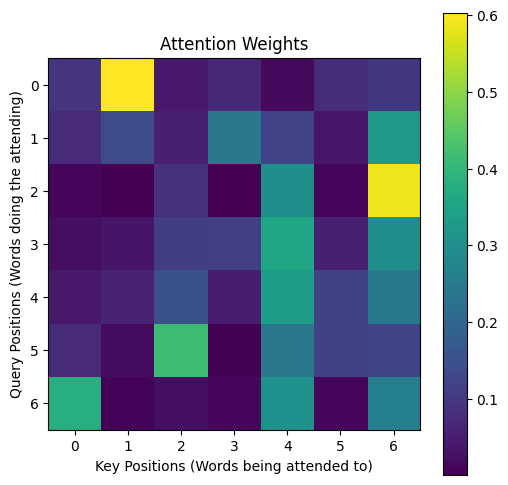

In [153]:
# Once we compute Q @ K, we apply an activation called Softmax, Softmax will signal the word whom is paying how much attention, whom is paying the most, the least, etc.
# dim=-1 means softmax is applied along the last dimension (each row sums to 1)
attention_weights = F.softmax(attention_scores, dim=-1)

print("Attention weights shape:", attention_weights.shape)
print("Attention weights (after softmax):", attention_weights)
print(
    "Sum of weights for first word:", attention_weights[0, 0, :].sum()
)  # Should be close to 1

# Visualize attention weights for the first (and only) sentence in the batch
plt.figure(figsize=(6, 6))
plt.imshow(
    attention_weights.squeeze(0).detach().cpu().numpy(),
    cmap="viridis",
    interpolation="nearest",
)
plt.title("Attention Weights")
plt.xlabel("Key Positions (Words being attended to)")
plt.ylabel("Query Positions (Words doing the attending)")
plt.colorbar()
plt.show()

# The more the yellow it is, the more it paid attention. First cell is the word "the" and "the" itself.
# The second cell is the word "the" and "cat, and so on...

In [154]:
# Now we compute the output, to get the actual value each word contains. The word will get most of the value from the word it paid the most attention to and the rest distributed to other words which aren't that important.
output = attention_weights @ V
# Shape: (batch_size, sequence_length, d_k) - each word's representation is now a weighted sum of V's

print("Output shape:", output.shape)
print("Output of attention:", output)

sentence_after_attention = (
    sentence + output
)  # Now, why did we add? Because we want our model to still remember the actual input we gave. There's also one more reason, its called Residual which is H(x) = F(x) + y => F(x) = H(x) - y, but we are not gonna talk about it yet.

print("Original sentence embedding for first word:", sentence[0, 0, :5])
print("Attention output for first word:", output[0, 0, :5])
print("Combined (residual) for first word:", sentence_after_attention[0, 0, :5])

Output shape: torch.Size([1, 7, 10])
Output of attention: tensor([[[ 0.3987, -0.2925,  0.0132,  0.5659, -0.2349, -0.2188,  0.3974,
           0.2512, -0.0958, -0.4393],
         [ 0.7310, -0.2600, -0.0018,  0.0701, -0.3640, -0.1686,  0.5299,
           0.2414, -0.0220, -0.0991],
         [ 1.4112, -0.3895, -0.0199, -0.4825, -0.6530, -0.0406,  0.9999,
           0.5630, -0.1254,  0.0761],
         [ 0.7180, -0.2356, -0.1699, -0.2698, -0.4807,  0.0569,  0.4236,
           0.5610, -0.1970, -0.5101],
         [ 0.6738, -0.1633, -0.2804, -0.2992, -0.3718,  0.1905,  0.3844,
           0.6223, -0.2318, -0.6423],
         [ 0.7267, -0.1101, -0.4679, -0.3680, -0.2611,  0.3927,  0.2890,
           0.7074, -0.2799, -0.8708],
         [ 0.5379,  0.0567, -0.2975, -0.5639, -0.3129,  0.0129,  0.8440,
           0.5001, -0.2772, -0.5530]]], grad_fn=<UnsafeViewBackward0>)
Original sentence embedding for first word: tensor([ 0.8984,  0.2571, -0.0590,  1.6468, -1.6583], grad_fn=<SliceBackward0>)
Attentio

In [155]:
# Layer Normalization
# We add a layer norm, which is basically standardizing the entire matrix row by row.
# Why? because we wanna make sure training is stabilized and gradients dont explode.
# LayerNorm normalizes across the features (embedding_dimension) for each item in the batch and sequence.

layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dimension)
sentence_after_norm = layer_norm1(sentence_after_attention)

print("After LayerNorm for first word:", sentence_after_norm[0, 0, :5])
print(
    "Mean of first word features after norm:", sentence_after_norm[0, 0, :].mean()
)  # Should be close to 0
print(
    "Std of first word features after norm:", sentence_after_norm[0, 0, :].std()
)  # Should be close to 1

# Add & Norm step 1 (after attention)
x = sentence + output  # Residual connection
x = layer_norm1(x)  # Layer Normalization

After LayerNorm for first word: tensor([ 0.7686, -0.1809, -0.1884,  1.4211, -1.5049], grad_fn=<SliceBackward0>)
Mean of first word features after norm: tensor(0., grad_fn=<MeanBackward0>)
Std of first word features after norm: tensor(1.0541, grad_fn=<StdBackward0>)


In [156]:
# Now, 'x' is the output of the self-attention sub-layer.
# Next is the Feed-Forward Network (FFN) sub-layer.

# The Feed-Forward Network usually consists of two linear layers with a ReLU activation in between.
# The first linear layer expands the dimension, and the second compresses it back.
ffn_hidden_dim = 4 * embedding_dimension # Commonly 4 times the embedding dimension
feed_forward_network = nn.Sequential(
    nn.Linear(embedding_dimension, ffn_hidden_dim),
    nn.ReLU(),
    nn.Linear(ffn_hidden_dim, embedding_dimension),
)

# Pass the output of the attention sub-layer through the FFN
ffn_output = feed_forward_network(x)

Why do we need a feed forward network?

> Well what does a neural network do? learn patterns in data right? we do the same here, we want to learn the patterns in our sentence. We want to learn the grammar, the context, etc. For example it could learn that "cat" is a noun and "sat" is a verb, or that "mat" is a noun too. All we did before was compute attention between each word but we specifically didn't make the model learn the patterns right? Well we do that step now! For example the word "bank" has several meanings depending on the context. River bank and State bank have totally different meanings right? All we did was compute attention between these words but we never really learnt what they actually meant depending on the context. This is why need a seperate neural network to understand the difference between words too.

In [157]:
# Add & Norm step 2 (after FFN)
# Create another LayerNorm for the FFN output
layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dimension)
encoder_block_output = x + ffn_output # Residual connection
encoder_block_output = layer_norm2(encoder_block_output) # Layer Normalization

# 'encoder_block_output' is the final output of one Transformer Encoder block.
print("Final output of encoder block for first word:", encoder_block_output[0,0,:5])
print(encoder_block_output.shape) # Should be [1, 7, 10]

Final output of encoder block for first word: tensor([ 0.6956, -0.1996, -0.3969,  1.4062, -1.3446], grad_fn=<SliceBackward0>)
torch.Size([1, 7, 10])


And that completes one pass through a Transformer Encoder block! We've covered word embeddings, positional encoding, scaled dot-product attention, residual connections, layer normalization, and the feed-forward network.

This `encoder_block_output` now contains richer, context-aware representations of each word in the input sentence. In a full Transformer model, you might stack several of these encoder blocks.

This gives a foundational understanding of the components. The next step would be to encapsulate these into reusable modules (like a `MultiHeadAttention` module, an `EncoderBlock` class) to build a full Transformer.

In [158]:
# Let's start with the building block for attention: a single attention head.
# This class is all about creating those Q, K, and V matrices we talked about from the input.
class SingleAttentionHead(nn.Module):
    """
    A single attention head.
    It takes the input embeddings and projects them into Query, Key, and Value spaces.
    Think of it as one perspective or 'head' looking at the input.
    """

    def __init__(self, embed_dim: int, head_dim: int):
        # embed_dim: This is the dimension of the input token embeddings (e.g., 512).
        # head_dim: This is the dimension for the Q, K, V for this specific head (e.g., 64 if embed_dim is 512 and you have 8 heads).
        super().__init__()
        # These are just linear layers (learnable weight matrices) to transform
        # the input 'x' into Q, K, and V. No bias needed, as per the paper.
        self.w_q = nn.Linear(embed_dim, head_dim, bias=False) # Query projection
        self.w_k = nn.Linear(embed_dim, head_dim, bias=False) # Key projection
        self.w_v = nn.Linear(embed_dim, head_dim, bias=False) # Value projection

    def forward(
        self, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass for SingleAttentionHead.

        Args:
            x (torch.Tensor): Input tensor.
                              Shape: [batch_size, seq_len, embed_dim].

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing Q, K, and V tensors.
                                                             Each tensor shape: [batch_size, seq_len, head_dim].
        """
        # x shape: [batch_size, seq_len, embed_dim]
        # We just pass the input 'x' through our linear layers.
        Q = self.w_q(x) # Shape: [batch_size, seq_len, head_dim]
        K = self.w_k(x) # Shape: [batch_size, seq_len, head_dim]
        V = self.w_v(x) # Shape: [batch_size, seq_len, head_dim]
        return Q, K, V

# Now, why stop at one head? Multi-Head Attention is where the magic really happens.
# We're basically doing what we did in SingleAttentionHead, but multiple times in parallel.
# Each head can learn different aspects of the relationships between words.
# One head might focus on syntactic relationships, another on semantic ones,
# one might track short-range dependencies, another long-range. It's like having a committee of experts.

In [159]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    It creates multiple SingleAttentionHead instances and concatenates their Q, K, V outputs.
    Note: This module *prepares* Q, K, V for multi-head attention; the actual attention
    calculation (scaled dot-product) happens outside this specific class in the TransformerBlock.
    """

    def __init__(self, heads: int, embed_dim: int):
        # heads: The number of parallel attention heads we want (e.g., 8).
        # embed_dim: Total dimension of the input token embeddings (e.g., 512).
        super().__init__()
        # It's crucial that the embedding dimension is divisible by the number of heads.
        # This way, we can split the 'embed_dim' evenly among the heads.
        assert embed_dim % heads == 0, "Embedding dimension must be divisible by the number of heads."

        self.head_dim = embed_dim // heads # Dimension for Q, K, V for each individual head.
        self.heads = heads                # Number of heads.

        # We create a list of 'SingleAttentionHead' modules, one for each head.
        # nn.ModuleList is important here so PyTorch recognizes these as submodules.
        self.heads_list = nn.ModuleList(
            [
                SingleAttentionHead(embed_dim=embed_dim, head_dim=self.head_dim)
                for _ in range(self.heads)
            ]
        )

    def forward(
        self, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass for MultiHeadAttention.

        Args:
            x (torch.Tensor): Input tensor.
                              Shape: [batch_size, seq_len, embed_dim].

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing the final Q, K, and V tensors
                                                             concatenated across all heads.
                                                             Q_final, K_final, V_final shapes: [batch_size, seq_len, embed_dim (which is heads * head_dim)].
        """
        q_list, k_list, v_list = [], [], []
        # Get Q, K, V from each head and store them.
        for head_module in self.heads_list:
            # Each 'head_module' is a SingleAttentionHead instance.
            q_single_head, k_single_head, v_single_head = head_module(x)
            q_list.append(q_single_head)
            k_list.append(k_single_head)
            v_list.append(v_single_head)

        # Now, concatenate the outputs from all heads along the last dimension (the feature dimension).
        # We do this to combine what every head has learned (or rather, their Q, K, V projections).
        # Each q_single_head, k_single_head, v_single_head has shape [batch_size, seq_len, head_dim].
        # After cat, Q, K, V will have shape [batch_size, seq_len, heads * head_dim],
        # which is effectively [batch_size, seq_len, embed_dim] because embed_dim = heads * head_dim.
        Q_final = torch.cat(q_list, dim=-1)
        K_final = torch.cat(k_list, dim=-1)
        V_final = torch.cat(v_list, dim=-1)

        return Q_final, K_final, V_final

In [160]:
# This is our simple feed-forward network. After attention, each token's representation
# is passed through this network independently.
# It's usually two linear layers with a non-linearity (like ReLU) in between.
class FeedForward(nn.Module):
    """
    A simple position-wise feed-forward network.
    It consists of two linear transformations with a ReLU activation in between.
    The input is expanded to `hidden_dim` and then contracted back to `embed_dim`.
    """
    def __init__(self, embed_dim: int, hidden_dim: int):
        # embed_dim: Dimension of the input (and output) features.
        # hidden_dim: Dimension of the inner layer (usually larger, e.g., 4 * embed_dim).
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim), # Expand
            nn.ReLU(),                       # Non-linearity
            nn.Linear(hidden_dim, embed_dim), # Contract
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: [batch_size, seq_len, embed_dim]
        # Output shape: [batch_size, seq_len, embed_dim]
        return self.net(x)

# For positional information, since we process all words at once,
# we need to explicitly tell the model about word order.
# This class creates learnable positional embeddings.
class PositionalEmbedding(nn.Module):
    """
    Learnable Positional Embeddings.
    Creates an embedding vector for each position up to `max_seq_len`.
    """
    def __init__(self, max_seq_len: int, embed_dim: int):
        # max_seq_len: The maximum length of an input sequence.
        # embed_dim: The dimension of the embeddings (must match word embeddings).
        super().__init__()
        # We use nn.Embedding to create learnable vectors for each position.
        self.pos_embed = nn.Embedding(max_seq_len, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is the input tensor (e.g., word embeddings), we only need its sequence length and device.
        # x shape: [batch_size, seq_len, embed_dim]
        seq_len = x.size(1)

        # Create a tensor of position indices: [0, 1, 2, ..., seq_len-1]
        # It's important to put these indices on the same device as 'x'.
        positions = torch.arange(seq_len, device=x.device)
        # positions shape: [seq_len]

        # Get the positional embeddings for these positions.
        # Output shape: [seq_len, embed_dim]
        # This will be broadcastable to add to x (if x is [batch_size, seq_len, embed_dim])
        # or you might need to unsqueeze if adding to something already having batch.
        # For adding to word embeddings (batch_size, seq_len, embed_dim), this works due to broadcasting.
        return self.pos_embed(positions)

In [161]:
import math

# Now, let's put it all together into one Transformer Encoder Block!
# This block will contain:
# 1. Multi-Head Self-Attention
# 2. Add & Norm (Residual connection + Layer Normalization)
# 3. Feed-Forward Network
# 4. Add & Norm (Again!)
# We're following the Pre-LayerNorm structure here, which means LayerNorm is applied *before*
# the main operation in each sub-layer. It often leads to more stable training.

class TransformerBlock(nn.Module):
    """
    A single Transformer Encoder Block.
    Implements Multi-Head Attention and a Feed-Forward network,
    each followed by a residual connection and layer normalization (Pre-LN style).
    """
    def __init__(
        self,
        heads: int,      # Number of attention heads
        embed_dim: int,  # Dimension of token embeddings (and model's hidden size)
        ff_hidden_dim: int, # Hidden dimension for the FeedForward network
    ):
        super().__init__()
        self.num_heads = heads # Storing for reshaping logic later
        self.head_dim = embed_dim // heads # Dimension per head

        # First sub-layer: Multi-Head Attention
        self.mha = MultiHeadAttention(heads=heads, embed_dim=embed_dim)
        # LayerNorm for the MHA sub-layer's input
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embed_dim)

        # Second sub-layer: Feed-Forward Network
        self.ffn = FeedForward(embed_dim=embed_dim, hidden_dim=ff_hidden_dim)
        # LayerNorm for the FFN sub-layer's input
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is the input to the block, shape: [batch_size, seq_len, embed_dim]

        # --- Multi-Head Attention Sub-layer (Pre-LN) ---
        # 1. Normalize the input 'x'. This is the "Pre" in Pre-LayerNorm.
        x_norm1 = self.layer_norm1(x)

        # 2. Get the Q, K, V projections, already concatenated from all heads by our MHA class.
        # Q_cat, K_cat, V_cat shapes: [batch_size, seq_len, embed_dim]
        Q_cat, K_cat, V_cat = self.mha(x_norm1)

        batch_size, seq_len, embed_dim_total = Q_cat.shape
        # num_heads = self.num_heads (or self.mha.heads)
        # head_dim = self.head_dim (or self.mha.head_dim)

        # 3. Reshape Q_cat, K_cat, V_cat to be per head for the actual attention calculation.
        # We need to get from [batch_size, seq_len, embed_dim_total]
        # to [batch_size, num_heads, seq_len, head_dim].
        # embed_dim_total is num_heads * head_dim.
        Q_reshaped = Q_cat.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K_reshaped = K_cat.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V_reshaped = V_cat.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # After transpose, shapes are [batch_size, num_heads, seq_len, head_dim]

        # 4. Scaled Dot-Product Attention - this is the core calculation, done per head.
        # (Q @ K.transpose) gives scores: [batch_size, num_heads, seq_len, seq_len]
        # I didn't mention scaling before, but it's important!
        # We scale by sqrt(head_dim) to prevent dot products from becoming too large,
        # which helps keep gradients stable, especially when head_dim is large.
        attention_scores = (Q_reshaped @ K_reshaped.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Apply softmax to get attention weights (probabilities).
        # dim=-1 ensures weights sum to 1 across each row of the seq_len x seq_len matrix.
        attention_weights = F.softmax(attention_scores, dim=-1)
        # attention_weights shape: [batch_size, num_heads, seq_len, seq_len]

        # Multiply weights by V_reshaped to get the weighted sum of values.
        # (attention_weights @ V_reshaped) -> [batch_size, num_heads, seq_len, head_dim]
        attention_output_heads = attention_weights @ V_reshaped

        # 5. Concatenate heads back to the original embedding dimension.
        # First, transpose to bring seq_len and num_heads dimensions adjacent for view:
        # [batch_size, seq_len, num_heads, head_dim]
        attention_output_concat = attention_output_heads.transpose(1, 2).contiguous()
        # Then, view to merge the last two dimensions (num_heads * head_dim = embed_dim_total)
        # Result shape: [batch_size, seq_len, embed_dim_total]
        attention_output_final = attention_output_concat.view(batch_size, seq_len, embed_dim_total)
        # This attention_output_final is the complete output of the MHA mechanism.

        # 6. Add residual connection for the attention sub-layer.
        # We add the output of MHA to the original input 'x' of this sub-layer (which is the block's input 'x').
        # This helps with vanishing gradients and allows the model to learn identity functions if needed.
        x_after_mha = x + attention_output_final
        # --- End of Multi-Head Attention Sub-layer ---

        # --- Feed-Forward Network Sub-layer (Pre-LN) ---
        # 7. Normalize the output from the MHA sub-layer (x_after_mha).
        x_norm2 = self.layer_norm2(x_after_mha)

        # 8. Pass it through the Feed-Forward Network.
        ffn_output = self.ffn(x_norm2)

        # 9. Add residual connection for the FFN sub-layer.
        # We add the output of FFN to the input of this FFN sub-layer (which was x_after_mha).
        x_after_ffn = x_after_mha + ffn_output
        # --- End of Feed-Forward Network Sub-layer ---

        return x_after_ffn

# And that's one Transformer Encoder block!
# You'd typically stack several of these blocks to build the full encoder.
# The output of one block becomes the input to the next.

In [162]:
# Now we build the full Encoder.
# The Encoder is basically a stack of our TransformerBlocks.
# It takes raw token IDs as input, embeds them, adds positional info,
# and then passes them through all the blocks.
class Encoder(nn.Module):
    """
    The Transformer Encoder module.
    It comprises an embedding layer for tokens, positional embeddings,
    a stack of Transformer Blocks, and a final layer normalization.
    """
    def __init__(
        self,
        layers_count: int,    # How many TransformerBlocks to stack (e.g., 6 or 12)
        heads_count: int,     # Number of attention heads in each TransformerBlock
        max_seq_len: int,   # Maximum sequence length this encoder can handle (for positional embeddings)
        vocab_size: int,    # Size of our vocabulary (how many unique tokens)
        embed_dim: int,     # Embedding dimension for tokens and throughout the model
        ff_hidden_dim: int,   # Hidden dimension for the FeedForward networks inside blocks
    ):
        super().__init__()

        # 1. Token Embedding: Converts input token IDs (integers) into dense vectors.
        # Each unique word/token in our vocab gets its own 'embed_dim'-sized vector.
        self.token_embed = nn.Embedding(vocab_size, embed_dim)

        # 2. Positional Embedding: Adds information about the position of each token in the sequence.
        # We use our previously defined learnable PositionalEmbedding class.
        self.pos_embed = PositionalEmbedding(
            max_seq_len=max_seq_len, embed_dim=embed_dim
        )

        # 3. Transformer Blocks: A stack of 'layers_count' TransformerBlocks.
        # nn.ModuleList is crucial here so PyTorch correctly registers all the blocks.
        # Each block will perform self-attention and feed-forward operations.
        self.blocks = nn.ModuleList(
            [
                TransformerBlock(
                    heads=heads_count,
                    embed_dim=embed_dim,
                    ff_hidden_dim=ff_hidden_dim, # Make sure to pass the correct hidden_dim arg name
                )
                for _ in range(layers_count) # Create 'layers_count' identical blocks
            ]
        )

        # 4. Final Layer Normalization: An additional LayerNorm after all blocks have processed the input.
        # This can help stabilize the final output of the encoder.
        self.final_norm = nn.LayerNorm(embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x starts as a tensor of token IDs.
        # Shape: [batch_size, seq_len]

        # Step 1: Get token embeddings.
        # Output shape: [batch_size, seq_len, embed_dim]
        token_embeddings = self.token_embed(x)

        # Step 2: Get positional embeddings and add them to token embeddings.
        # self.pos_embed(token_embeddings) will generate positional embeddings for the given seq_len.
        # The output of self.pos_embed will be [seq_len, embed_dim],
        # which will be broadcasted across the batch dimension when added to token_embeddings.
        # This is the final input representation before it goes into the blocks.
        # Shape: [batch_size, seq_len, embed_dim]
        x_with_pos = token_embeddings + self.pos_embed(token_embeddings) # Pass the embedded tensor to get seq_len and device

        # Step 3: Pass the embeddings through each TransformerBlock in sequence.
        # The output of one block becomes the input to the next.
        processed_x = x_with_pos
        for block in self.blocks:
            processed_x = block(processed_x)
        # Shape after blocks: [batch_size, seq_len, embed_dim]

        # Step 4: Apply the final layer normalization.
        # Shape: [batch_size, seq_len, embed_dim]
        final_output = self.final_norm(processed_x)

        return final_output

#### So we have successfully built the encoder. Well, thats it for now.

#### In the next notebook we will learn how to use the encoder to classify imdb reviews for sentiment analysis.

#### And soon learn how to build the decoder to create GPT style models too.